## Setup and Configuration
This initial block sets up the environment, defines file paths, and specifies the validation scans and model versions to be analyzed.

In [1]:
from pipeline.paths import Directories, Files
import os
import torch
import numpy as np
import gc
import matplotlib.pyplot as plt
# from sklearn.isotonic import IsotonicRegression

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if torch.cuda.is_available():
    CUDA_DEVICE = torch.device("cuda:0")
    print(f"CUDA is available. Using device: {CUDA_DEVICE}")
else:
    print("CUDA is not available. Please check your PyTorch installation. Using CPU instead.")
    CUDA_DEVICE = torch.device("cpu")

PHASE = '7'
DATA_VERSION = '13'


# Base directory
WORK_ROOT = "D:/NoahSilverberg/ngCBCT"

# NSG_CBCT Path where the raw matlab data is stored
NSG_CBCT_PATH = "D:/MitchellYu/NSG_CBCT"

# Directory with all files specific to this phase/data version
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)

DIRECTORIES = Directories(
    # mat_projections_dir=os.path.join(NSG_CBCT_PATH, "data/prj/HF/mat"),
    # pt_projections_dir=os.path.join(WORK_ROOT, "prj_pt"),
    # projections_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "projections"),
    # projections_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "projections"),
    # projections_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "projections"),
    # projections_gated_dir=os.path.join(WORK_ROOT, "gated", "prj_mat"),
    reconstructions_dir=os.path.join(PHASE_DATAVER_DIR, "reconstructions"),
    reconstructions_gated_dir=os.path.join(WORK_ROOT, "gated", "fdk_recon"),
    # reconstructions_dir=os.path.join("H:\\", "Public", "Noah", "reconstructions"),
    # reconstructions_gated_dir=os.path.join("H:\\", "Public", "Noah", "gated", "fdk_recon"),
    images_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "images"),
    # images_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "images"),
    # images_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "images"),
)

FILES = Files(DIRECTORIES)

# VAL_SCANS = [('02', '01') , ('02', '02'), ('16', '01'), ('16', '02')] # , ('22', '01'), ('22', '02')]
VAL_SCANS = [('08', '01'), ('10', '01'), ('14', '01'), ('14', '02'), ('15', '01'), ('20', '01')]

SCAN_TYPE = 'HF'
# MODEL_VERSIONS = ['MK7_MCDROPOUT_30_pct']
MODEL_VERSIONS = ['MK7_MCDROPOUT_15_pct']
# MODEL_VERSIONS = ['MK7_MCDROPOUT_50_pct']
PASSTHROUGH_COUNT = 50 # use None for multiple models -- only use this for one model for MC dropout

CUDA is available. Using device: cuda:0


## Data Loading
This block gathers the file paths for the model's reconstructions (50 passes for MC Dropout) and the corresponding ground truth reconstructions.

In [2]:
recon_paths_dict = {}
recon_names_dict = {}
gt_paths_dict = {}

for patient, scan in VAL_SCANS:
    print(f"Processing patient {patient}, scan {scan}")
    recon_paths = []
    recon_names = []
    if PASSTHROUGH_COUNT is None:
        for model_version in MODEL_VERSIONS:
            recon_path = FILES.get_recon_filepath(model_version, patient, scan, SCAN_TYPE, gated=False)
            recon_paths.append(recon_path)
            recon_names.append(model_version)
    else:
        for i in range(PASSTHROUGH_COUNT):
            recon_path = FILES.get_recon_filepath(MODEL_VERSIONS[0], patient, scan, SCAN_TYPE, gated=False, passthrough_num=i)
            recon_paths.append(recon_path)
            recon_names.append(f"Passthrough {i+1}")

    gt_path = FILES.get_recon_filepath('fdk', patient, scan, SCAN_TYPE, gated=True)
    gt_paths_dict[(patient, scan)] = gt_path

    recon_paths_dict[(patient, scan)] = recon_paths
    recon_names_dict[(patient, scan)] = recon_names

Processing patient 08, scan 01
Processing patient 10, scan 01
Processing patient 14, scan 01
Processing patient 14, scan 02
Processing patient 15, scan 01
Processing patient 20, scan 01


## Analysis Loop
The main loop iterates through each scan. For each scan, it loads all 50 reconstruction passes, calculates the mean (prediction) and standard deviation (uncertainty), and then performs several analyses to evaluate the quality of the uncertainty estimates.

In [ ]:
# Now go through each patient and scan, load the reconstructions
# calclate the mean and std (pixel-wise) and the error from GT
for (patient, scan), recon_paths in recon_paths_dict.items():
    print(f"\nProcessing reconstructions for patient {patient}, scan {scan}")
    
    # --- MODIFICATION: Apply clip-and-scale to Ground Truth ---
    gt_path = gt_paths_dict[(patient, scan)]
    gt_recon_raw = torch.load(gt_path).cpu().numpy()
    gt_tensor = torch.from_numpy(gt_recon_raw)
    gt_processed_tensor = torch.permute(torch.clip(gt_tensor, 0, 0.04) * 25.0, (0, 2, 1))
    gt_recon = gt_processed_tensor.cpu().numpy()
    del gt_recon_raw, gt_tensor, gt_processed_tensor
    
    # Initialize lists to hold reconstructions
    reconstructions = []
    
    for recon_path in recon_paths:
        recon_raw = torch.load(recon_path).cpu().numpy()
        
        # --- MODIFICATION: Apply clip-and-scale to each Reconstruction ---
        recon_tensor = torch.from_numpy(recon_raw)
        recon_processed_tensor = torch.permute(torch.clip(recon_tensor, 0, 0.04) * 25.0, (0, 2, 1))
        recon = recon_processed_tensor.cpu().numpy()
        reconstructions.append(recon)

    print(f"Loaded and processed {len(reconstructions)} reconstructions for patient {patient}, scan {scan}")
    
    # Convert to numpy array for easier manipulation
    reconstructions = np.array(reconstructions)
    
    # --- Basic Calculations ---
    # Calculate mean and std across the first axis (across models or passthroughs)
    mean_recon = np.mean(reconstructions, axis=0)
    std_recon = np.std(reconstructions, axis=0)

    # Plot the 100th slice of the mean reconstruction and GT and uncertainty and abs error
    slice_index = 100
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(mean_recon[slice_index], cmap='gray')
    plt.title(f'Mean Reconstruction - Patient {patient}, Scan {scan}')
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(gt_recon[slice_index], cmap='gray')
    plt.title(f'Ground Truth Reconstruction - Patient {patient}, Scan {scan}')
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.imshow(std_recon[slice_index], cmap='inferno')
    plt.title(f'Standard Deviation of Reconstructions - Patient {patient}, Scan {scan}')
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(np.abs(mean_recon[slice_index] - gt_recon[slice_index]), cmap='viridis')
    plt.title(f'Absolute Error - Patient {patient}, Scan {scan}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Calculate error from ground truth
    error = mean_recon - gt_recon
    
    # Efficiently create a circular mask in the last two dimensions
    z, y, x = gt_recon.shape
    yy, xx = np.ogrid[:y, :x]
    center = np.array([y // 2, x // 2])
    radius = 225
    dist_from_center = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    slice_mask = dist_from_center <= radius
    mask = np.broadcast_to(slice_mask, gt_recon.shape)
    
    flat_std = std_recon[mask].flatten()
    flat_error = error[mask].flatten()
    flat_abs_error = np.abs(flat_error)
    flat_squared_error = flat_error**2

    # Clean up memory
    del reconstructions, mean_recon, std_recon, error, gt_recon
    gc.collect()

    # --- Analysis 1: Standardized Error Histogram (Your Original Analysis) ---
    standardized_error = flat_error / (flat_std + 1e-8)
    plt.figure(figsize=(10, 6))
    plt.hist(standardized_error, bins=100, color='gray', alpha=0.7, range=(-30, 30))
    plt.title(f'UNCALIBRATED Standardized Error Histogram for Patient {patient}, Scan {scan}')
    plt.xlabel('Standardized Error (Error / Predicted Std Dev)')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    percent_within_1 = np.mean(np.abs(standardized_error) < 1) * 100
    percent_within_2 = np.mean(np.abs(standardized_error) < 2) * 100
    percent_within_3 = np.mean(np.abs(standardized_error) < 3) * 100
    print(f"Patient {patient}, Scan {scan} - UNCALIBRATED Coverage:")
    print(f"  Percent with abs standardized error < 1: {percent_within_1:.2f}% (Expected for Gaussian: ~68%)")
    print(f"  Percent with abs standardized error < 2: {percent_within_2:.2f}% (Expected for Gaussian: ~95%)")
    print(f"  Percent with abs standardized error < 3: {percent_within_3:.2f}% (Expected for Gaussian: ~99.7%)")

    # --- Analysis 2 & 3: Plots for Hyperparameter Tuning (Visual) ---
    plt.figure(figsize=(10, 8))
    plt.hist2d(flat_std, flat_abs_error, bins=50, cmap='inferno', range=[[0, 0.0005], [0, 0.005]])
    plt.xlim(0, 0.0005)
    plt.ylim(0, 0.005)
    plt.colorbar(label='Voxel Count')
    plt.title(f'Predicted Uncertainty vs. Actual Error for Patient {patient}, Scan {scan}')
    plt.xlabel('Predicted Standard Deviation (Uncertainty)')
    plt.ylabel('Absolute Error')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    sorted_indices = np.argsort(flat_std)
    sorted_squared_error = flat_squared_error[sorted_indices]
    fractions_removed = np.linspace(0, 0.5, 51)
    mse_remaining = np.zeros_like(fractions_removed)
    for i, frac in enumerate(fractions_removed):
        num_to_keep = int((1 - frac) * len(sorted_squared_error))
        mse_remaining[i] = np.mean(sorted_squared_error[:num_to_keep]) if num_to_keep > 0 else 0
    plt.figure(figsize=(10, 6))
    plt.plot(fractions_removed * 100, mse_remaining, 'o-', color='crimson')
    plt.title(f'Sparsification Plot for Patient {patient}, Scan {scan}')
    plt.xlabel('Percent of Most Uncertain Voxels Removed (%)')
    plt.ylabel('Mean Squared Error (on remaining voxels)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Analysis 4: Quantitative Tuning Metrics (New Section) ---
    # These single numbers help decide which dropout rate is better by focusing on correlation
    # and ranking, ignoring the bad scaling of the raw uncertainty.
    
    # Spearman's Rank Correlation: Measures if high uncertainty ranks correspond to high error ranks. Higher is better.
    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(flat_std, flat_abs_error)
    
    # Area Under Sparsification Curve (AUSC): Quantifies the sparsification plot. Lower is better.
    ausc = np.trapz(mse_remaining, fractions_removed)

    print(f"\n--- Quantitative Tuning Metrics for Patient {patient}, Scan {scan} ---")
    print(f"  Spearman's Rank Correlation: {spearman_corr:.4f} (Higher is better)")
    print(f"  Area Under Sparsification Curve (AUSC): {ausc:.6e} (Lower is better)")
    
    # --- Analysis 5: Post-Hoc Uncertainty Calibration (Updated Section) ---
    print("\n--- Calibration Results ---")

    # Method 1: Linear Calibration
    p_linear = np.polyfit(flat_std, flat_abs_error, 1)
    calibrated_std_linear = np.polyval(p_linear, flat_std)
    calibrated_std_linear[calibrated_std_linear < 0] = 0

    # Method 2: Binned (Isotonic-like) Calibration (No sklearn needed)
    # This method learns the average error for different levels of predicted uncertainty.
    num_bins_calib = 100
    # Sort data by predicted std to make binning efficient
    sort_indices_calib = np.argsort(flat_std)
    sorted_std_calib = flat_std[sort_indices_calib]
    sorted_sq_err_calib = flat_squared_error[sort_indices_calib]
    
    # Create bins with roughly equal numbers of points
    bin_boundaries = np.quantile(sorted_std_calib, np.linspace(0, 1, num_bins_calib + 1))
    
    calibrated_std_binned = np.zeros_like(flat_std)
    
    for i in range(num_bins_calib):
        lower = bin_boundaries[i]
        upper = bin_boundaries[i+1]
        # Find all voxels that fall into this uncertainty bin
        in_bin = (flat_std >= lower) & (flat_std <= upper)
        if np.any(in_bin):
            # Calculate the true average error (RMSE) for all voxels in this bin
            true_rmse_in_bin = np.sqrt(np.mean(flat_squared_error[in_bin]))
            # Assign this true RMSE as the calibrated uncertainty for all those voxels
            calibrated_std_binned[in_bin] = true_rmse_in_bin

    # --- Visualize the Calibrated Results ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Calibration Plots for Patient {patient}, Scan {scan}')

    num_bins_plot = 100 # Can use fewer bins for a cleaner plot

    # Linear Calibration Plot (using Quantile Bins for plotting)
    bin_limits_lin = np.quantile(calibrated_std_linear, np.linspace(0, 1, num_bins_plot + 1))
    rmse_per_bin_lin = [np.sqrt(np.mean(flat_squared_error[(calibrated_std_linear >= ll) & (calibrated_std_linear < ul)])) if np.any((calibrated_std_linear >= ll) & (calibrated_std_linear < ul)) else 0 for ll, ul in zip(bin_limits_lin[:-1], bin_limits_lin[1:])]
    mean_std_per_bin_lin = [np.mean(calibrated_std_linear[(calibrated_std_linear >= ll) & (calibrated_std_linear < ul)]) if np.any((calibrated_std_linear >= ll) & (calibrated_std_linear < ul)) else 0 for ll, ul in zip(bin_limits_lin[:-1], bin_limits_lin[1:])]
    ax1.plot(mean_std_per_bin_lin, rmse_per_bin_lin, 'o-', label='Linear Calibration', color='green')
    lims1 = [0, max(np.max(mean_std_per_bin_lin), np.max(rmse_per_bin_lin))]
    ax1.plot(lims1, lims1, 'k--', label='Perfect Calibration')
    ax1.set_title('After Linear Calibration'); ax1.set_xlabel('Avg. Pred. Std'); ax1.set_ylabel('RMSE'); ax1.legend(); ax1.grid(True, alpha=0.5); ax1.axis('equal');

    # Binned Calibration Plot (using Quantile Bins for plotting)
    bin_limits_binned = np.quantile(calibrated_std_binned, np.linspace(0, 1, num_bins_plot + 1))
    rmse_per_bin_binned = [np.sqrt(np.mean(flat_squared_error[(calibrated_std_binned >= ll) & (calibrated_std_binned < ul)])) if np.any((calibrated_std_binned >= ll) & (calibrated_std_binned < ul)) else 0 for ll, ul in zip(bin_limits_binned[:-1], bin_limits_binned[1:])]
    mean_std_per_bin_binned = [np.mean(calibrated_std_binned[(calibrated_std_binned >= ll) & (calibrated_std_binned < ul)]) if np.any((calibrated_std_binned >= ll) & (calibrated_std_binned < ul)) else 0 for ll, ul in zip(bin_limits_binned[:-1], bin_limits_binned[1:])]
    ax2.plot(mean_std_per_bin_binned, rmse_per_bin_binned, 'o-', label='Binned Calibration', color='purple')
    lims2 = [0, max(np.max(mean_std_per_bin_binned), np.max(rmse_per_bin_binned))]
    ax2.plot(lims2, lims2, 'k--', label='Perfect Calibration')
    ax2.set_title('After Binned (Isotonic-like) Calibration'); ax2.set_xlabel('Avg. Pred. Std'); ax2.set_ylabel('RMSE'); ax2.legend(); ax2.grid(True, alpha=0.5); ax2.axis('equal');
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # --- Final Metrics After Calibration ---
    # Now that the uncertainty is scaled correctly, we can calculate meaningful absolute metrics.
    calibrated_standardized_error_linear = flat_error / (calibrated_std_linear + 1e-8)
    percent_within_1_linear = np.mean(np.abs(calibrated_standardized_error_linear) < 1) * 100
    
    calibrated_standardized_error_binned = flat_error / (calibrated_std_binned + 1e-8)
    percent_within_1_binned = np.mean(np.abs(calibrated_standardized_error_binned) < 1) * 100

    # Calibrated Negative Log-Likelihood (NLL)
    # This is a key metric. A lower NLL indicates a better overall model (accuracy + uncertainty).
    # Use the calibrated variance (std^2) for this calculation.
    nll_linear = np.mean(0.5 * flat_squared_error / (calibrated_std_linear**2 + 1e-8) + 0.5 * np.log(calibrated_std_linear**2 + 1e-8))
    nll_binned = np.mean(0.5 * flat_squared_error / (calibrated_std_binned**2 + 1e-8) + 0.5 * np.log(calibrated_std_binned**2 + 1e-8))

    print(f"--- Final Calibrated Metrics for Patient {patient}, Scan {scan} ---")
    print(f"  Coverage (Ideal is ~68%):")
    print(f"    [Linear]   Percent of errors within 1 calibrated sigma: {percent_within_1_linear:.2f}%")
    print(f"    [Binned]   Percent of errors within 1 calibrated sigma: {percent_within_1_binned:.2f}%")
    print(f"  Calibrated Negative Log-Likelihood (Lower is better):")
    print(f"    [Linear]   NLL: {nll_linear:.4f}")
    print(f"    [Binned]   NLL: {nll_binned:.4f}")
    
    # Clean up memory
    del flat_std, flat_error, flat_abs_error, flat_squared_error, standardized_error
    del calibrated_std_linear, calibrated_std_binned
    gc.collect()

# Analysis: Calibration then look at hold-out

In [4]:
import random
from scipy.stats import spearmanr, probplot
import numpy as np
import matplotlib.pyplot as plt
import gc
import torch

# --- 0. Define Bin Counts to Compare ---
BIN_COUNTS_TO_TEST = [30, 100, 300]

# --- 1. Create a Train/Test Split for Calibration ---
# Using a fixed split for reproducibility, but you can re-enable shuffle
# random.shuffle(VAL_SCANS) 
# split_point = len(VAL_SCANS) // 2
# calibration_scans = VAL_SCANS[:split_point]
# evaluation_scans = VAL_SCANS[split_point:]
calibration_scans = VAL_SCANS[:2]
evaluation_scans = VAL_SCANS[2:]

print(f"Total scans: {len(VAL_SCANS)}")
print(f"Calibration Set (for learning the map): {calibration_scans}")
print(f"Evaluation Set (for testing the map): {evaluation_scans}")


# --- 2. Learn the Calibration Map from the Calibration Set ---
all_calib_std = []
all_calib_abs_error = []
all_calib_squared_error = []

print("\n--- Aggregating data from calibration set... ---")
for (patient, scan) in calibration_scans:
    print(f"  Loading data for calibration from: Patient {patient}, Scan {scan}")
    
    gt_path = gt_paths_dict[(patient, scan)]
    gt_tensor = torch.load(gt_path).cpu()
    gt_processed_tensor = torch.permute(torch.clip(gt_tensor, 0, 0.04) * 25.0, (0, 2, 1))[20:-20, :, :]
    gt_recon = gt_processed_tensor.numpy()
    del gt_tensor, gt_processed_tensor
    
    reconstructions = []
    recon_paths = recon_paths_dict[(patient, scan)]
    for recon_path in recon_paths:
        recon_tensor = torch.load(recon_path).cpu()
        recon_processed_tensor = torch.permute(torch.clip(recon_tensor, 0, 0.04) * 25.0, (0, 2, 1))[20:-20, :, :]
        reconstructions.append(recon_processed_tensor.numpy())
        del recon_tensor, recon_processed_tensor
    
    reconstructions = np.array(reconstructions)
    
    mean_recon = np.mean(reconstructions, axis=0)
    std_recon = np.std(reconstructions, axis=0)
    error = mean_recon - gt_recon
    
    z, y, x = gt_recon.shape
    yy, xx = np.ogrid[:y, :x]
    center = np.array([y // 2, x // 2])
    radius = 225
    dist_from_center = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    slice_mask = dist_from_center <= radius
    mask = np.broadcast_to(slice_mask, gt_recon.shape)
    
    all_calib_std.append(std_recon[mask].flatten())
    all_calib_abs_error.append(np.abs(error[mask].flatten()))
    all_calib_squared_error.append((error[mask].flatten())**2)

    del reconstructions, mean_recon, std_recon, error, gt_recon
    gc.collect()

calib_flat_std = np.concatenate(all_calib_std)
calib_flat_abs_error = np.concatenate(all_calib_abs_error)
calib_flat_squared_error = np.concatenate(all_calib_squared_error)

print("\n--- Training calibration models... ---")

# Train Linear Calibration Model
linear_calib_coeffs = np.polyfit(calib_flat_std, calib_flat_abs_error, 1)
print(f"Learned Linear Calibration: y = {linear_calib_coeffs[0]:.2f}x + {linear_calib_coeffs[1]:.4f}")

# Train Multiple Binned Calibration Models
binned_calib_models = {}
for n_bins in BIN_COUNTS_TO_TEST:
    bin_boundaries = np.quantile(calib_flat_std, np.linspace(0, 1, n_bins + 1))
    binned_calib_rmse_map = np.zeros(n_bins)
    for i in range(n_bins):
        lower = bin_boundaries[i]
        upper = bin_boundaries[i+1]
        if i == n_bins - 1:
            in_bin = (calib_flat_std >= lower) & (calib_flat_std <= upper)
        else:
            in_bin = (calib_flat_std >= lower) & (calib_flat_std < upper)
        
        if np.any(in_bin):
            binned_calib_rmse_map[i] = np.sqrt(np.mean(calib_flat_squared_error[in_bin]))
    binned_calib_models[n_bins] = (bin_boundaries, binned_calib_rmse_map)
    print(f"Learned Binned Calibration map with {n_bins} bins.")

del all_calib_std, all_calib_abs_error, all_calib_squared_error
del calib_flat_std, calib_flat_abs_error, calib_flat_squared_error
gc.collect()


# --- 3. Evaluate the Calibration on the Hold-Out Evaluation Set ---
print("\n--- Evaluating calibration on hold-out evaluation set... ---")
for (patient, scan) in evaluation_scans:
    print(f"\n--- Results for Patient {patient}, Scan {scan} (Evaluation Set) ---")
    
    gt_path = gt_paths_dict[(patient, scan)]
    gt_tensor = torch.load(gt_path).cpu()
    gt_processed_tensor = torch.permute(torch.clip(gt_tensor, 0, 0.04) * 25.0, (0, 2, 1))
    gt_recon = gt_processed_tensor.numpy()
    del gt_tensor, gt_processed_tensor
    
    reconstructions = []
    recon_paths = recon_paths_dict[(patient, scan)]
    for recon_path in recon_paths:
        recon_tensor = torch.load(recon_path).cpu()
        recon_processed_tensor = torch.permute(torch.clip(recon_tensor, 0, 0.04) * 25.0, (0, 2, 1))
        reconstructions.append(recon_processed_tensor.numpy())
        del recon_tensor, recon_processed_tensor
        
    reconstructions = np.array(reconstructions)
    
    mean_recon = np.mean(reconstructions, axis=0)
    std_recon = np.std(reconstructions, axis=0)
    error = mean_recon - gt_recon

    # Apply all learned calibration maps to the full 3D volume
    calibrated_std_recon_linear = np.polyval(linear_calib_coeffs, std_recon)
    calibrated_std_recon_linear[calibrated_std_recon_linear < 0] = 0

    calibrated_std_recons_binned = {}
    for n_bins, (boundaries, rmse_map) in binned_calib_models.items():
        bin_indices_3d = np.searchsorted(boundaries, std_recon, side='right') - 1
        bin_indices_3d = np.clip(bin_indices_3d, 0, n_bins - 1)
        calibrated_std_recons_binned[n_bins] = rmse_map[bin_indices_3d]

    # tumor location
    tlocs = torch.load(
        os.path.join(
            "D:/NoahSilverberg/ngCBCT/3D_recon",
            (
                "tumor_location.pt"
            ),
        ),
        weights_only=False,
    )
    tloc = tlocs[int(patient), int(scan)]

    tloc[2] -= 20  # adjust for slice trimming

    # --- Visual Slice Comparison (2x4 Plot) ---
    slice_index = tloc[2]
    
    gt_slice = gt_recon[slice_index, :, :]
    mean_slice = mean_recon[slice_index, :, :]
    abs_error_slice = np.abs(error[slice_index, :, :])
    raw_std_slice = std_recon[slice_index, :, :]
    calib_std_slice_linear = calibrated_std_recon_linear[slice_index, :, :]
    calib_std_slice_binned_30 = calibrated_std_recons_binned[30][slice_index, :, :]
    calib_std_slice_binned_300 = calibrated_std_recons_binned[300][slice_index, :, :]
    
    fig, axs = plt.subplots(2, 4, figsize=(26, 13))
    fig.suptitle(f'Visual Comparison for Patient {patient}, Scan {scan}, Slice {slice_index}', fontsize=20)
    vmax = np.percentile(abs_error_slice, 99.5)

    axs[0, 0].imshow(gt_slice, cmap='gray', vmin=0, vmax=1); axs[0, 0].set_title('Ground Truth', fontsize=16); axs[0, 0].axis('off')
    axs[0, 1].imshow(mean_slice, cmap='gray', vmin=0, vmax=1); axs[0, 1].set_title('Mean Reconstruction', fontsize=16); axs[0, 1].axis('off')
    im_err = axs[0, 2].imshow(abs_error_slice, cmap='hot', vmin=0, vmax=vmax); axs[0, 2].set_title('Absolute Error', fontsize=16); axs[0, 2].axis('off')
    fig.colorbar(im_err, ax=axs[0, 2], orientation='vertical', fraction=0.046, pad=0.04)
    axs[0, 3].axis('off') # Keep this one empty

    im_raw = axs[1, 0].imshow(raw_std_slice, cmap='hot', vmin=0, vmax=vmax); axs[1, 0].set_title('Raw Uncertainty', fontsize=16); axs[1, 0].axis('off')
    fig.colorbar(im_raw, ax=axs[1, 0], orientation='vertical', fraction=0.046, pad=0.04)
    im_lin = axs[1, 1].imshow(calib_std_slice_linear, cmap='hot', vmin=0, vmax=vmax); axs[1, 1].set_title('Linearly Calibrated', fontsize=16); axs[1, 1].axis('off')
    fig.colorbar(im_lin, ax=axs[1, 1], orientation='vertical', fraction=0.046, pad=0.04)
    im_b30 = axs[1, 2].imshow(calib_std_slice_binned_30, cmap='hot', vmin=0, vmax=vmax); axs[1, 2].set_title('Binned Calib. (30 bins)', fontsize=16); axs[1, 2].axis('off')
    fig.colorbar(im_b30, ax=axs[1, 2], orientation='vertical', fraction=0.046, pad=0.04)
    im_b300 = axs[1, 3].imshow(calib_std_slice_binned_300, cmap='hot', vmin=0, vmax=vmax); axs[1, 3].set_title('Binned Calib. (300 bins)', fontsize=16); axs[1, 3].axis('off')
    fig.colorbar(im_b300, ax=axs[1, 3], orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    
    # Quantitative analysis on flattened, masked data
    z, y, x = gt_recon.shape
    yy, xx = np.ogrid[:y, :x]
    center = np.array([y // 2, x // 2])
    radius = 225
    dist_from_center = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    slice_mask = dist_from_center <= radius
    mask = np.broadcast_to(slice_mask, gt_recon.shape)
    
    eval_flat_error = error[mask].flatten()
    eval_flat_squared_error = eval_flat_error**2
    
    print(f"--- Final Quantitative Metrics for Patient {patient}, Scan {scan} (Evaluation Set) ---")
    
    # Store residuals for Q-Q plots later
    all_residuals = {}

    # Linear model metrics
    calib_lin_flat = calibrated_std_recon_linear[mask].flatten()
    all_residuals['Linear'] = eval_flat_error / (calib_lin_flat + 1e-8)
    percent_within_1_linear = np.mean(np.abs(all_residuals['Linear']) < 1) * 100
    nll_linear = np.mean(0.5 * eval_flat_squared_error / (calib_lin_flat**2 + 1e-8) + 0.5 * np.log(calib_lin_flat**2 + 1e-8))
    
    print(f"\n  Linear Calibration:")
    print(f"    Coverage (Ideal ~68%): {percent_within_1_linear:.2f}%")
    print(f"    NLL (Lower is better): {nll_linear:.4f}")

    # Binned models metrics
    for n_bins in BIN_COUNTS_TO_TEST:
        calib_binned_flat = calibrated_std_recons_binned[n_bins][mask].flatten()
        all_residuals[f'{n_bins} Bins'] = eval_flat_error / (calib_binned_flat + 1e-8)
        
        percent_within_1_binned = np.mean(np.abs(all_residuals[f'{n_bins} Bins']) < 1) * 100
        nll_binned = np.mean(0.5 * eval_flat_squared_error / (calib_binned_flat**2 + 1e-8) + 0.5 * np.log(calib_binned_flat**2 + 1e-8))
        
        print(f"\n  Binned Calibration ({n_bins} bins):")
        print(f"    Coverage (Ideal ~68%): {percent_within_1_binned:.2f}%")
        print(f"    NLL (Lower is better): {nll_binned:.4f}")

    # --- Final Diagnostic: Q-Q Plots for All Calibration Models ---
    print("\n--- Q-Q Plots for All Calibration Models ---")
    
    fig, axs = plt.subplots(1, 4, figsize=(32, 8), sharey=True)
    fig.suptitle('Q-Q Plot of Calibrated Standardized Residuals (Comparing All Methods)', fontsize=18)
    
    plot_keys = ['Linear'] + [f'{n} Bins' for n in BIN_COUNTS_TO_TEST]

    for i, key in enumerate(plot_keys):
        residuals = all_residuals[key]
        plot_residuals = np.random.choice(residuals, size=min(50000, len(residuals)), replace=False)
        
        probplot(plot_residuals, dist="norm", plot=axs[i])
        
        axs[i].set_title(f'Q-Q Plot ({key})', fontsize=14)
        axs[i].set_xlabel('Theoretical Quantiles', fontsize=12)
        axs[i].grid(True, linestyle='--', alpha=0.6)
        axs[i].get_lines()[0].set_markersize(2.0)
        axs[i].get_lines()[1].set_color('red')
        axs[i].get_lines()[1].set_linestyle('--')

    axs[0].set_ylabel('Sample Quantiles', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    del reconstructions, mean_recon, std_recon, error, gt_recon
    gc.collect()

Total scans: 6
Calibration Set (for learning the map): [('08', '01'), ('10', '01')]
Evaluation Set (for testing the map): [('14', '01'), ('14', '02'), ('15', '01'), ('20', '01')]

--- Aggregating data from calibration set... ---
  Loading data for calibration from: Patient 08, Scan 01
torch.Size([200, 512, 512])


RuntimeError: No active exception to reraise

Total scans: 4
Calibration Set (for learning the map): [('02', '01'), ('02', '02')]
Evaluation Set (for testing the map): [('16', '01'), ('16', '02')]

--- Aggregating data from calibration set... ---
  Loading data for calibration from: Patient 02, Scan 01
  Loading data for calibration from: Patient 02, Scan 02

--- Training calibration models... ---
Learned Linear Calibration: y = 2.51x + 0.0022
Learned Binned Calibration map with 30 bins.
Learned Binned Calibration map with 100 bins.
Learned Binned Calibration map with 300 bins.

--- Evaluating calibration on hold-out evaluation set... ---

--- Results for Patient 16, Scan 01 (Evaluation Set) ---


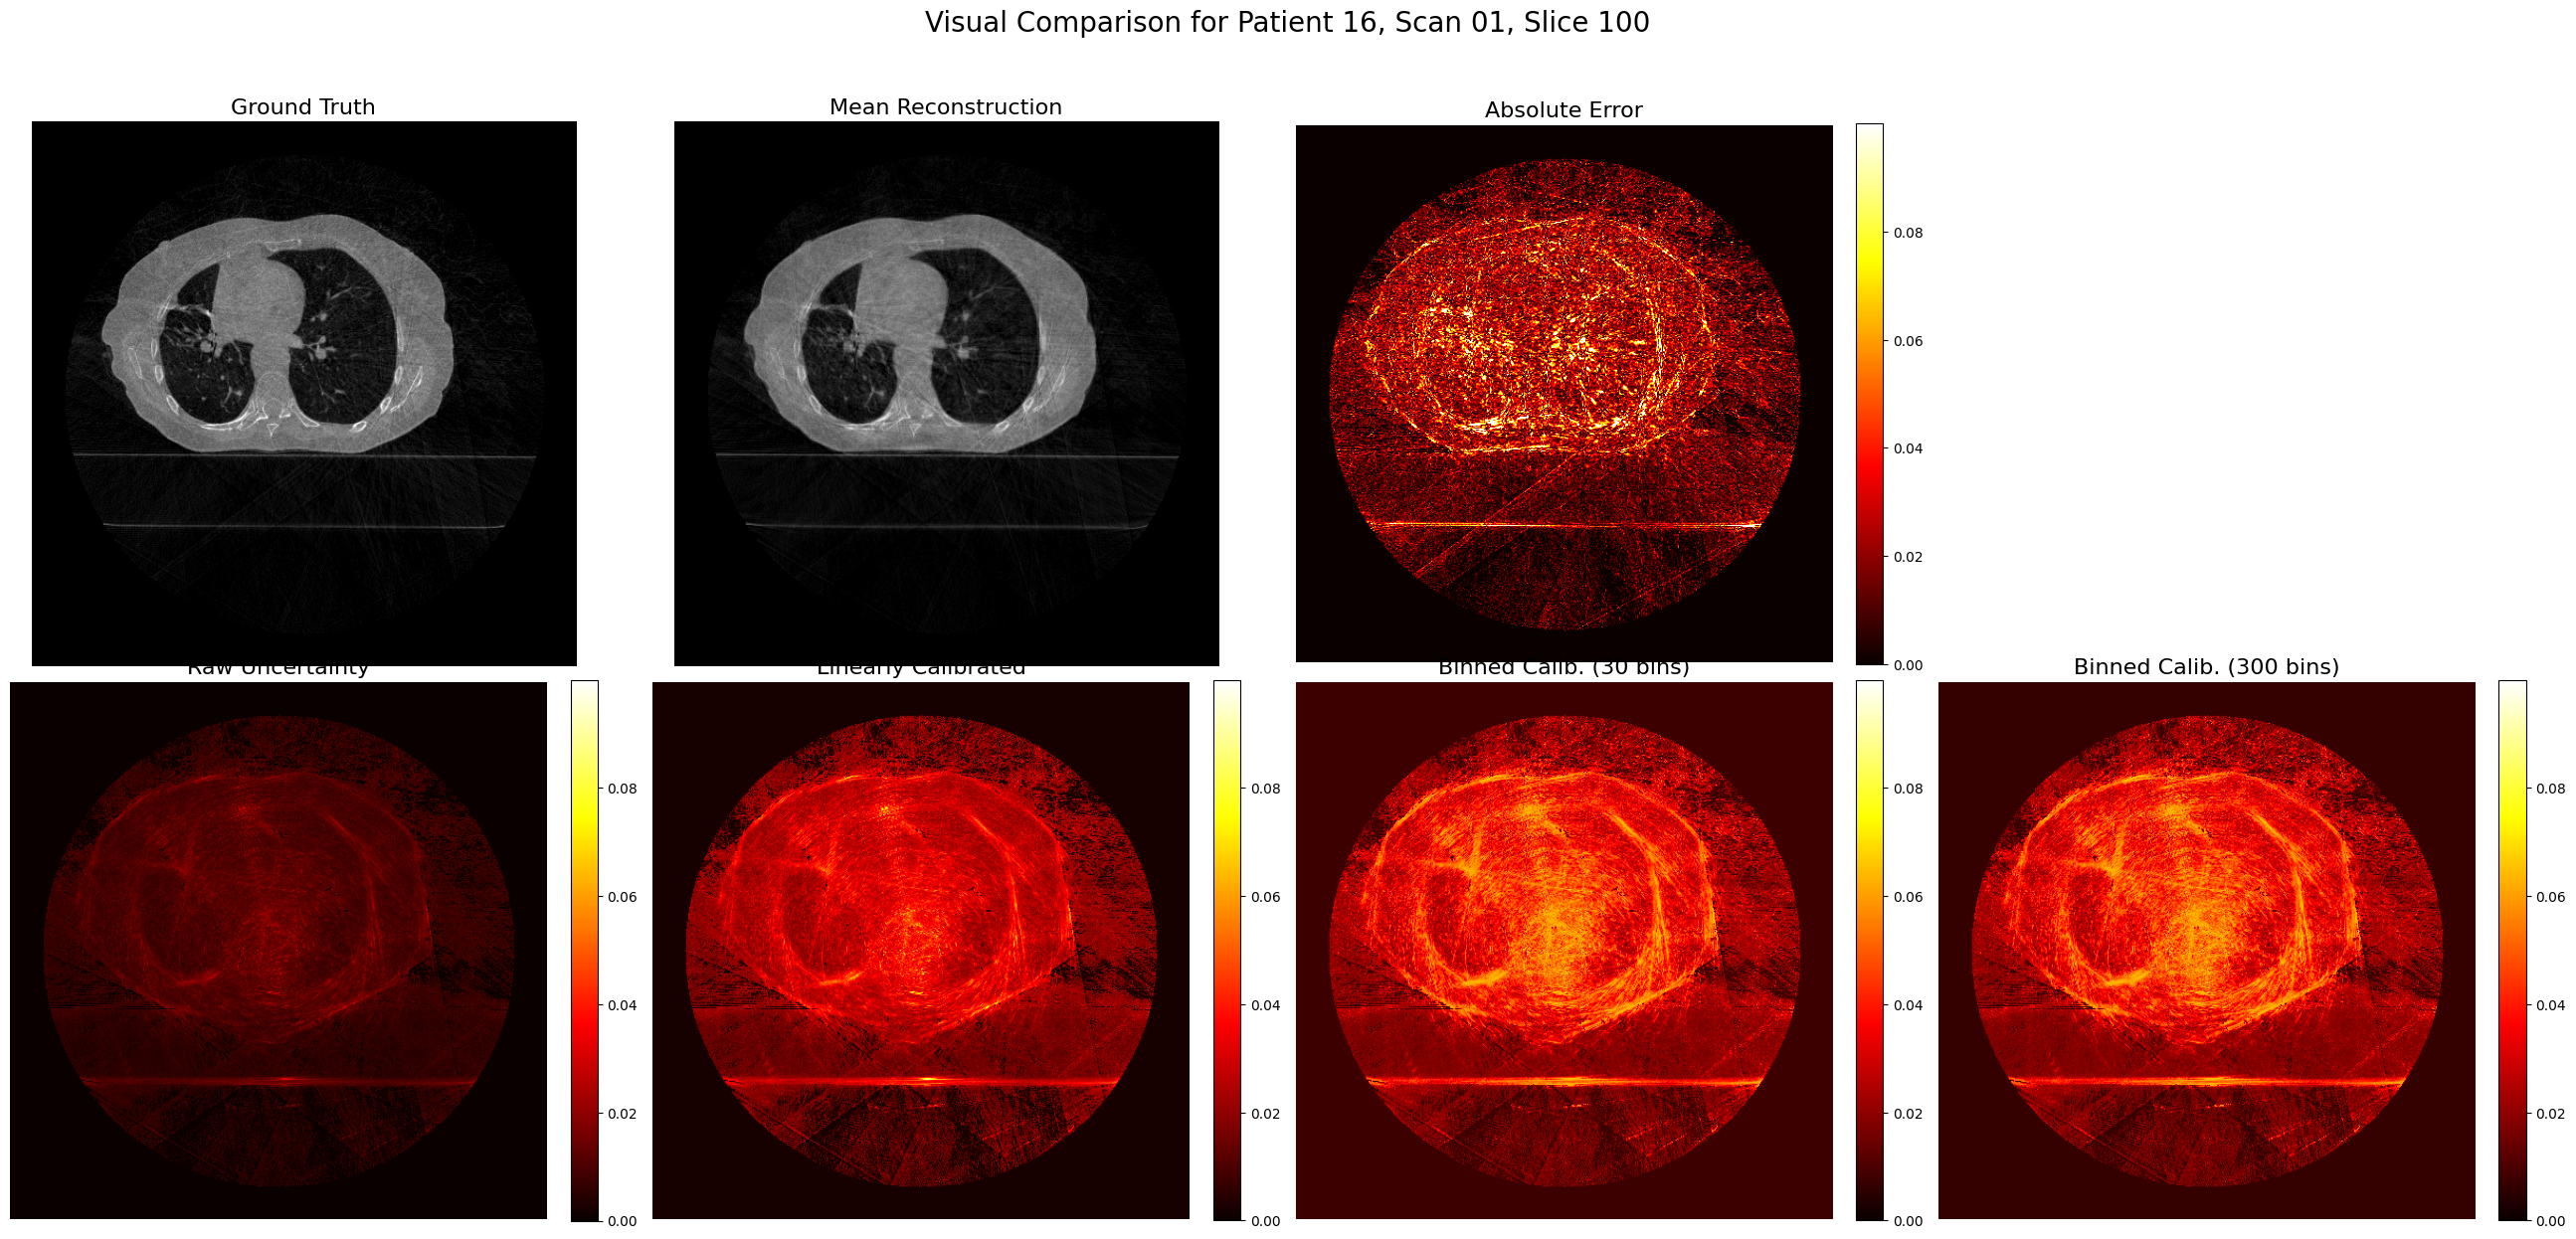

--- Final Quantitative Metrics for Patient 16, Scan 01 (Evaluation Set) ---

  Linear Calibration:
    Coverage (Ideal ~68%): 72.32%
    NLL (Lower is better): -3.2480

  Binned Calibration (30 bins):
    Coverage (Ideal ~68%): 82.54%
    NLL (Lower is better): -3.3432

  Binned Calibration (100 bins):
    Coverage (Ideal ~68%): 82.60%
    NLL (Lower is better): -3.3547

  Binned Calibration (300 bins):
    Coverage (Ideal ~68%): 82.60%
    NLL (Lower is better): -3.3562

--- Q-Q Plots for All Calibration Models ---


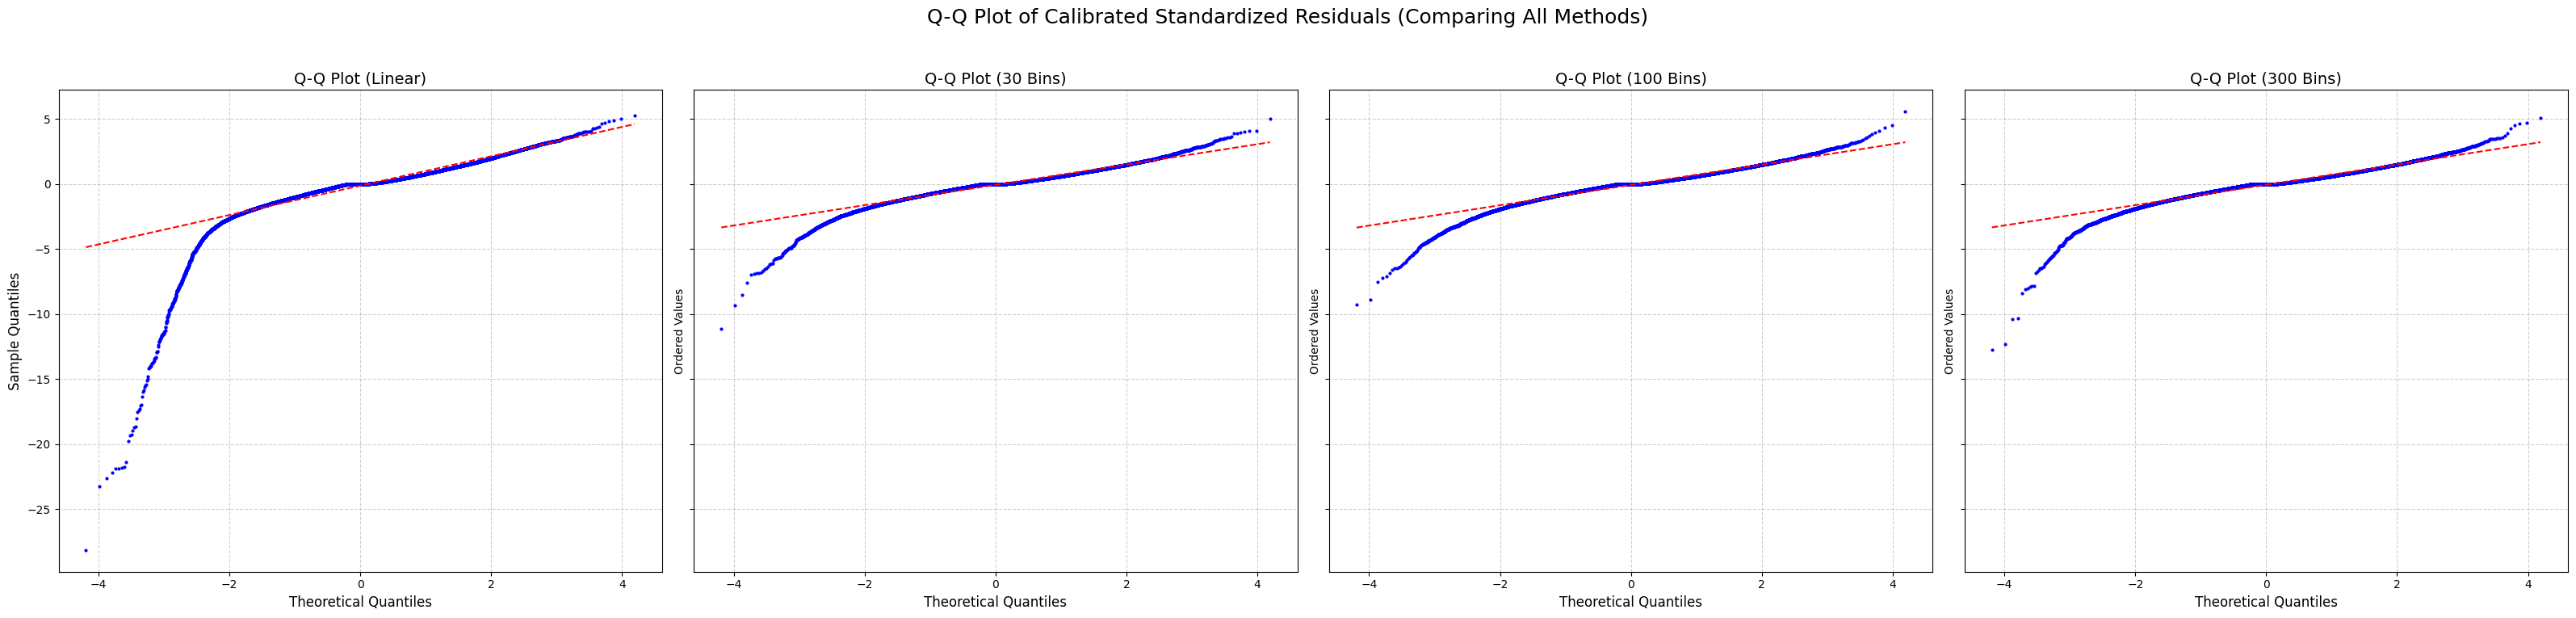


--- Results for Patient 16, Scan 02 (Evaluation Set) ---


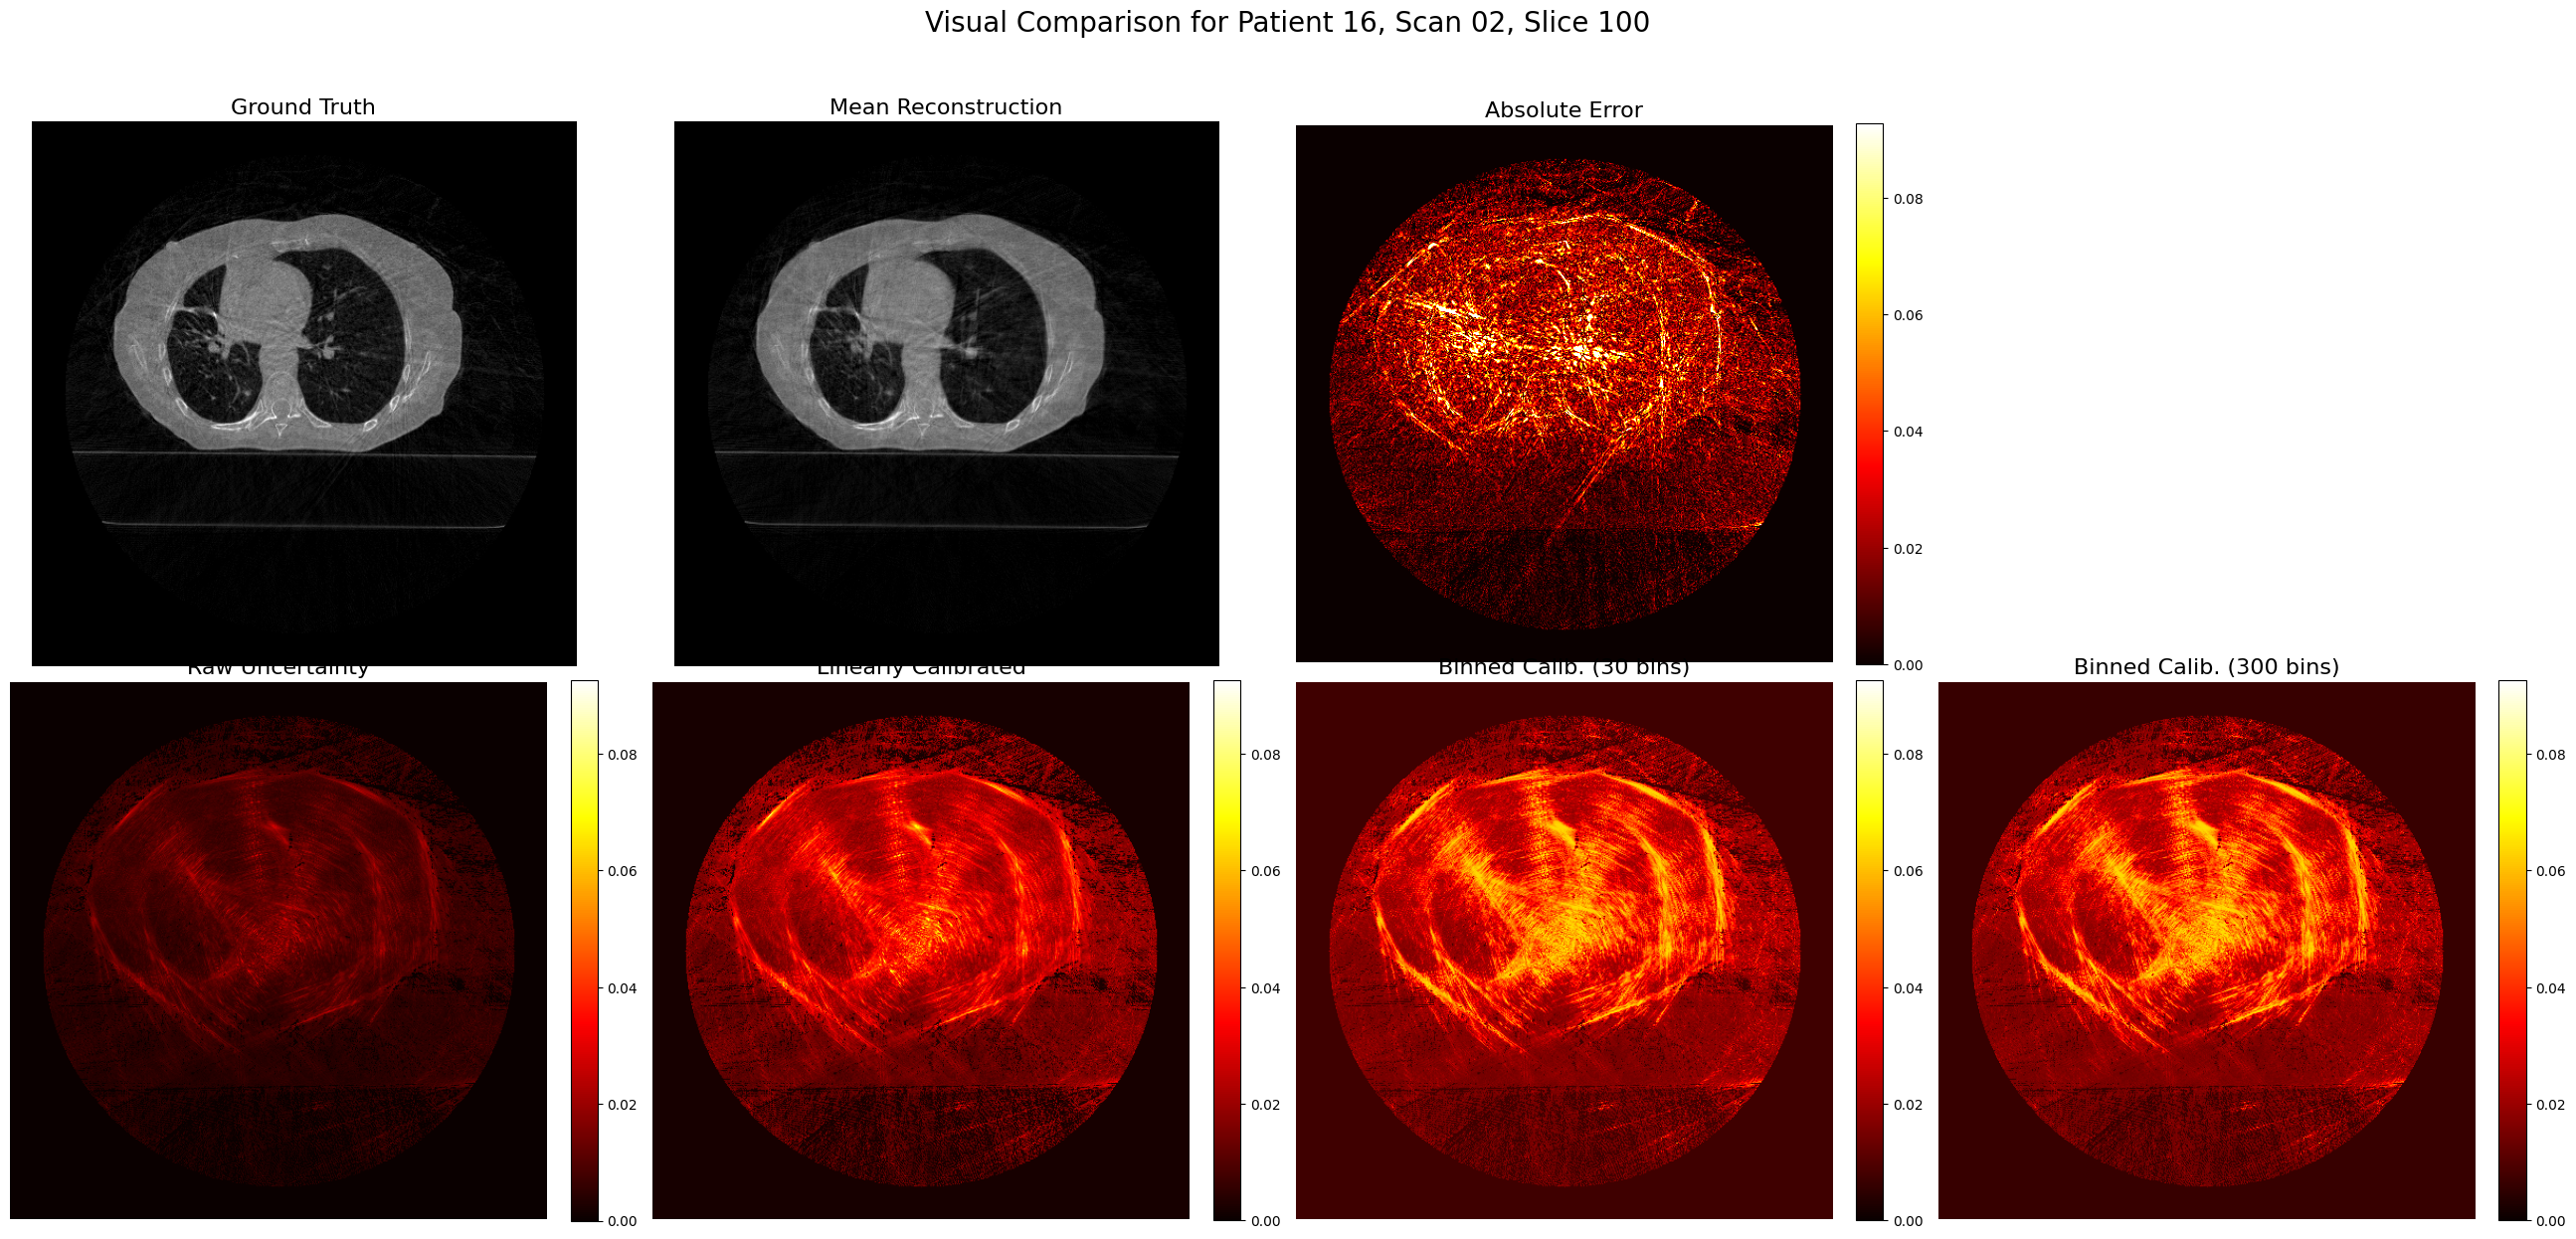

--- Final Quantitative Metrics for Patient 16, Scan 02 (Evaluation Set) ---

  Linear Calibration:
    Coverage (Ideal ~68%): 73.36%
    NLL (Lower is better): -3.4758

  Binned Calibration (30 bins):
    Coverage (Ideal ~68%): 82.70%
    NLL (Lower is better): -3.4933

  Binned Calibration (100 bins):
    Coverage (Ideal ~68%): 82.78%
    NLL (Lower is better): -3.5061

  Binned Calibration (300 bins):
    Coverage (Ideal ~68%): 82.79%
    NLL (Lower is better): -3.5076

--- Q-Q Plots for All Calibration Models ---


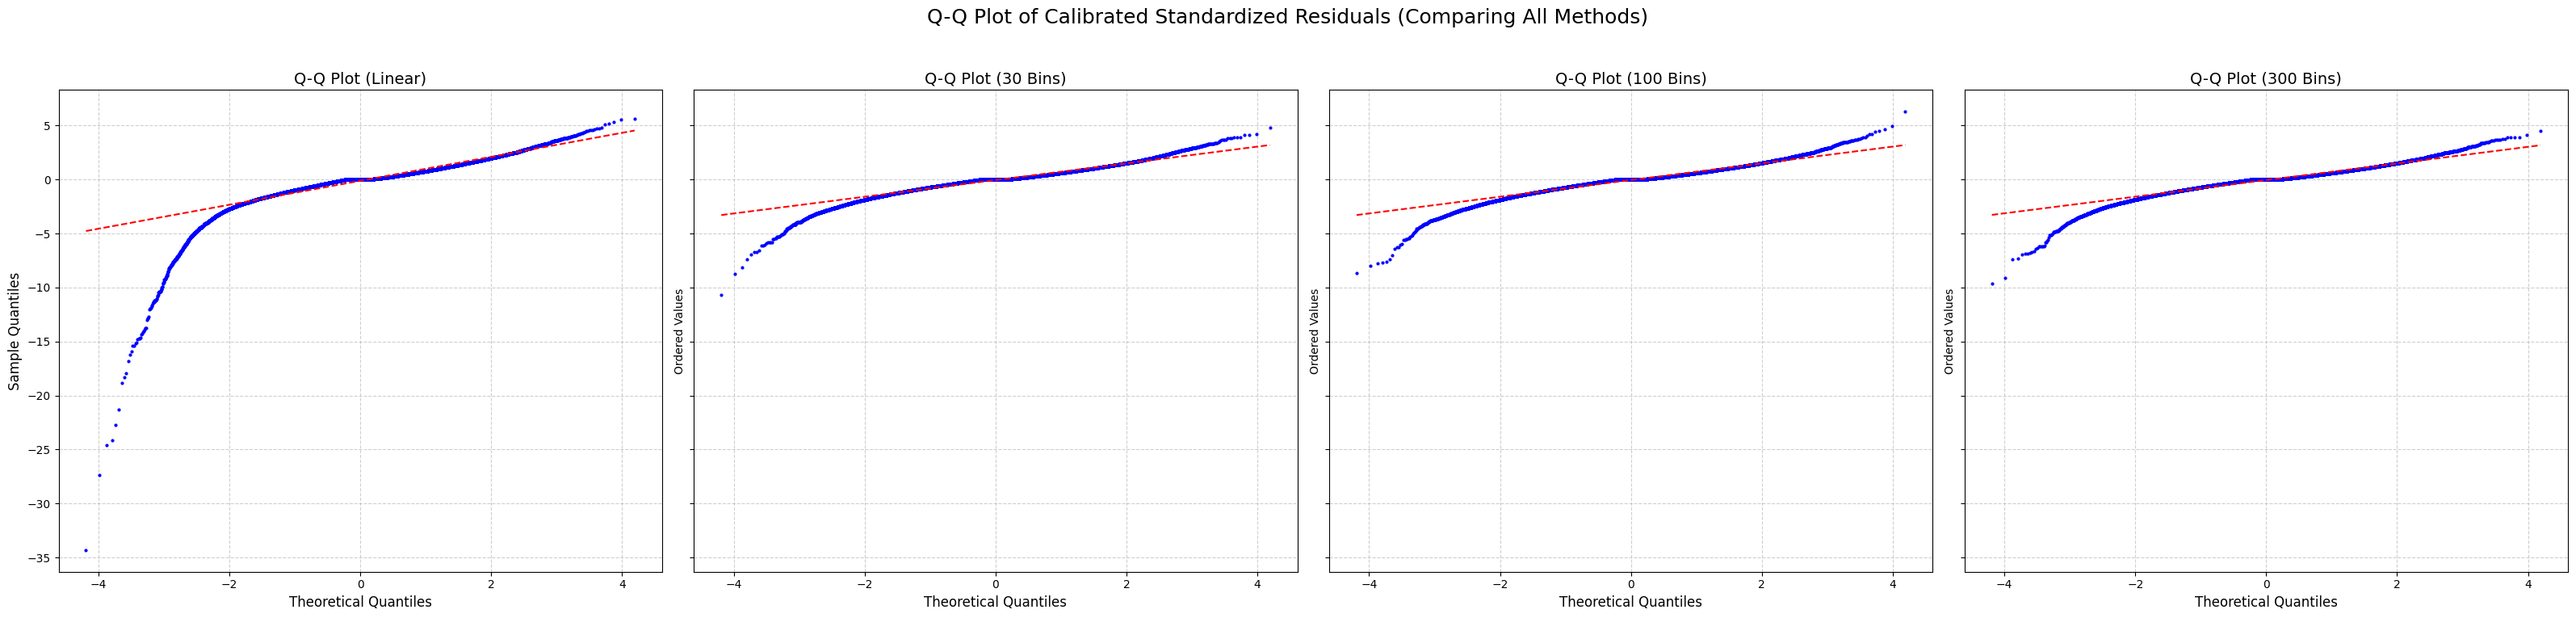

In [3]:
# 50 pct

Total scans: 4
Calibration Set (for learning the map): [('02', '01'), ('02', '02')]
Evaluation Set (for testing the map): [('16', '01'), ('16', '02')]

--- Aggregating data from calibration set... ---
  Loading data for calibration from: Patient 02, Scan 01
  Loading data for calibration from: Patient 02, Scan 02

--- Training calibration models... ---
Learned Linear Calibration: y = 2.98x + 0.0022
Learned Binned Calibration map with 30 bins.
Learned Binned Calibration map with 100 bins.
Learned Binned Calibration map with 300 bins.

--- Evaluating calibration on hold-out evaluation set... ---

--- Results for Patient 16, Scan 01 (Evaluation Set) ---


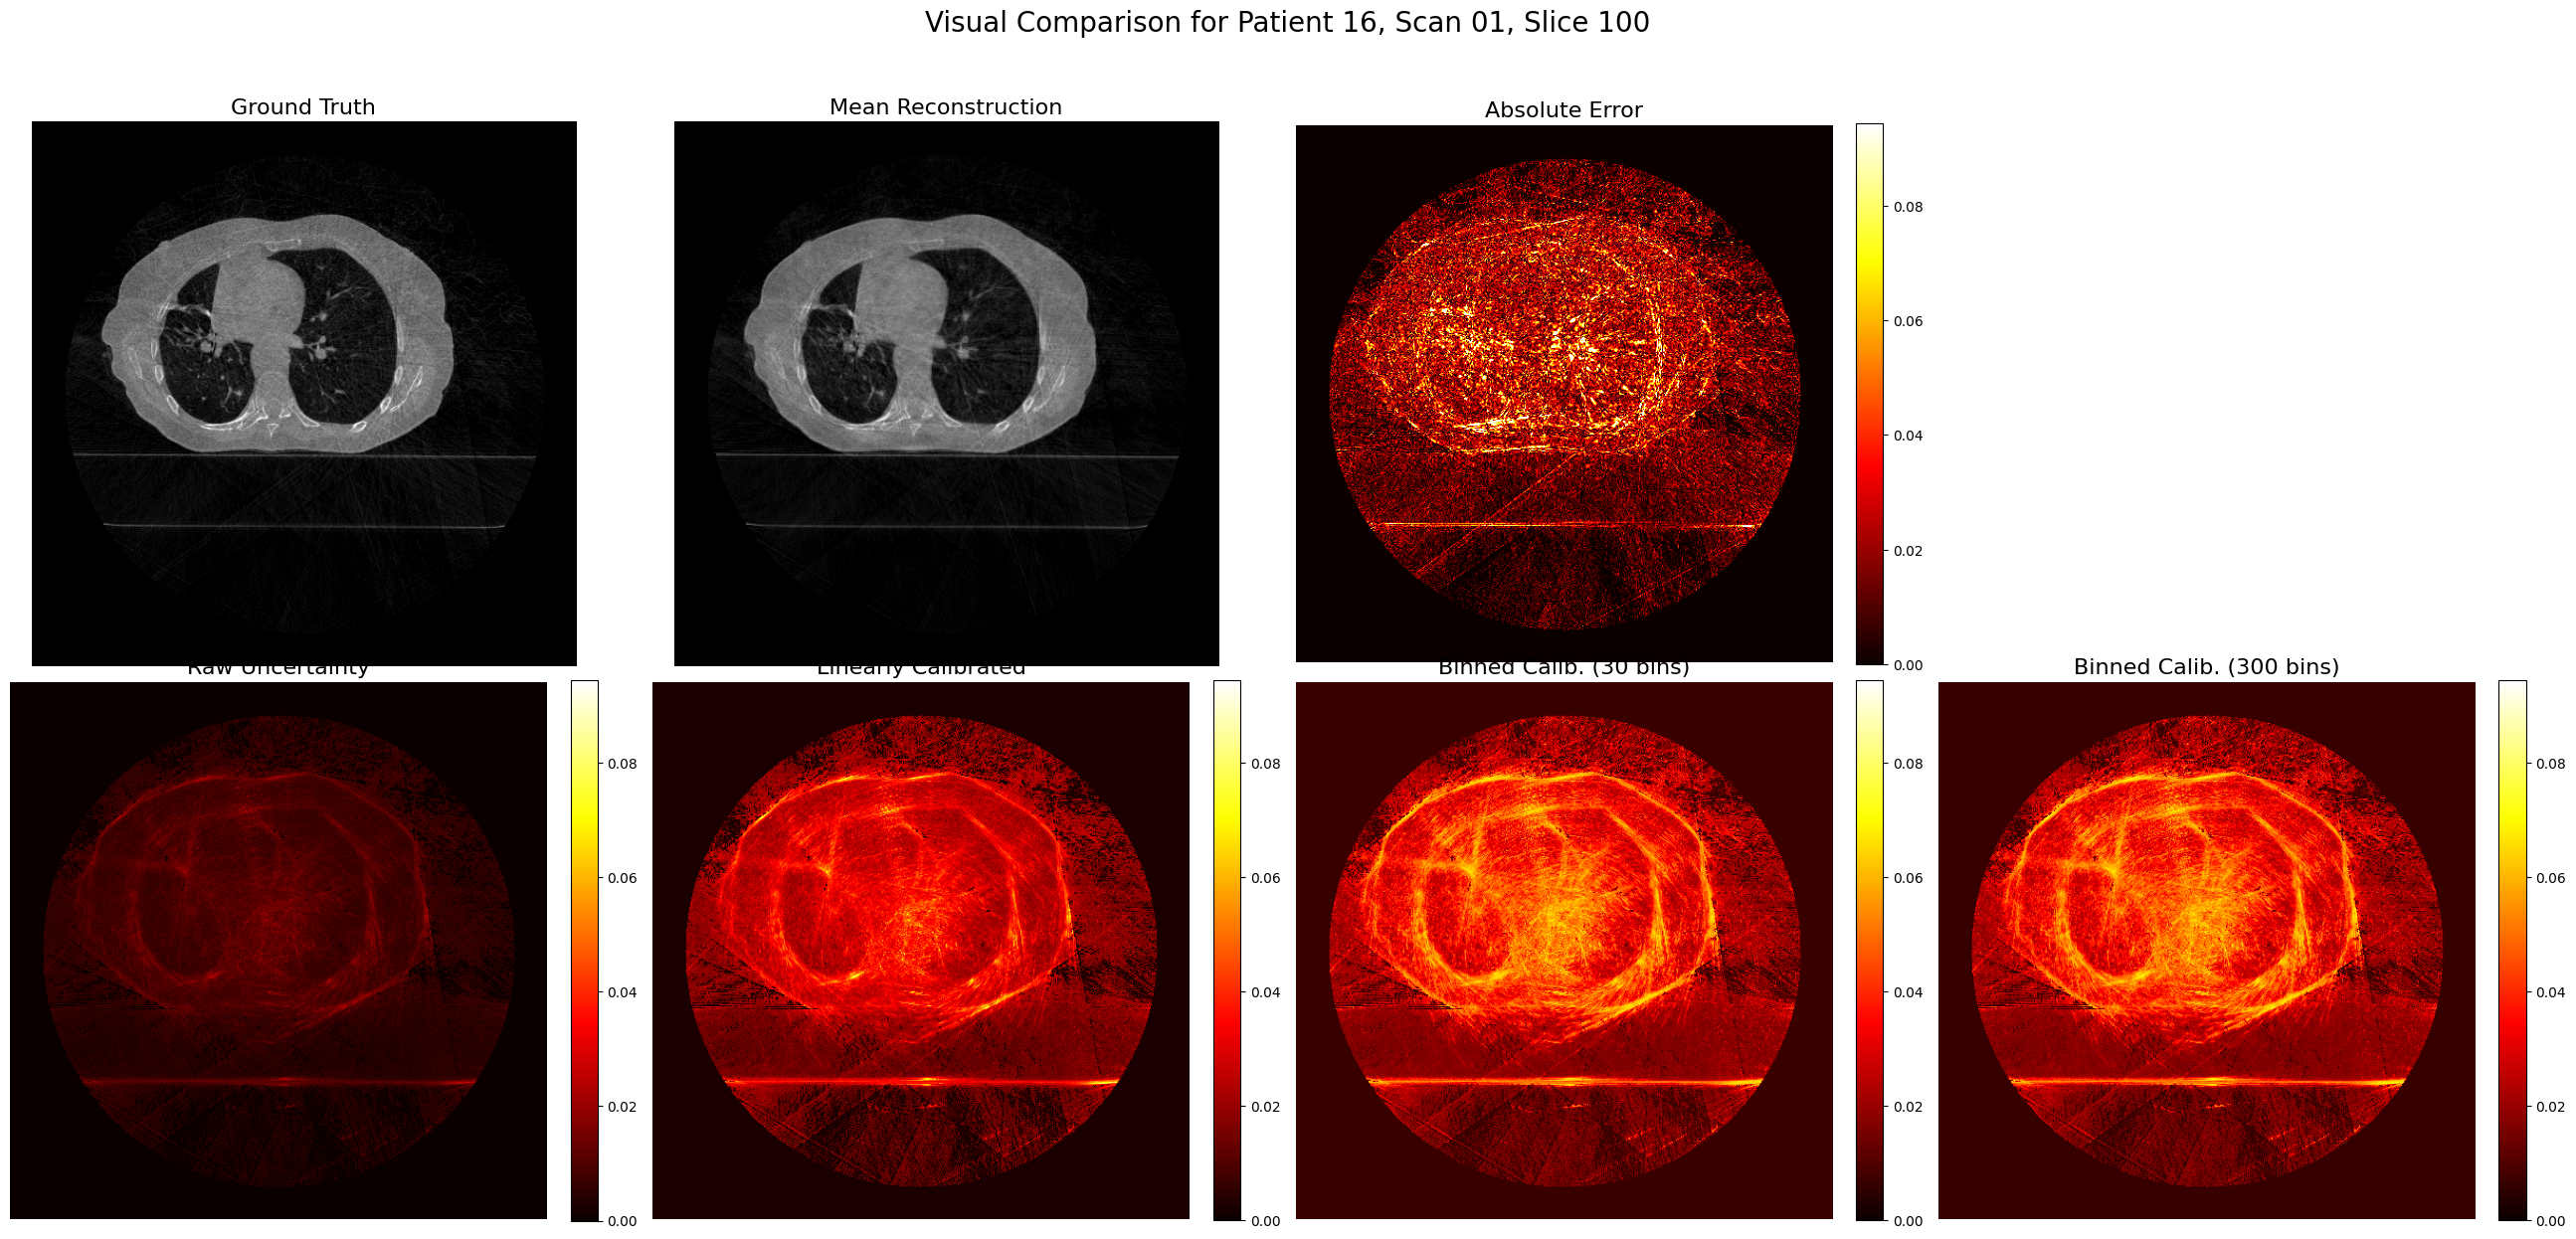

--- Final Quantitative Metrics for Patient 16, Scan 01 (Evaluation Set) ---

  Linear Calibration:
    Coverage (Ideal ~68%): 72.21%
    NLL (Lower is better): -3.2397

  Binned Calibration (30 bins):
    Coverage (Ideal ~68%): 82.50%
    NLL (Lower is better): -3.3840

  Binned Calibration (100 bins):
    Coverage (Ideal ~68%): 82.51%
    NLL (Lower is better): -3.3876

  Binned Calibration (300 bins):
    Coverage (Ideal ~68%): 82.52%
    NLL (Lower is better): -3.3907

--- Q-Q Plots for All Calibration Models ---


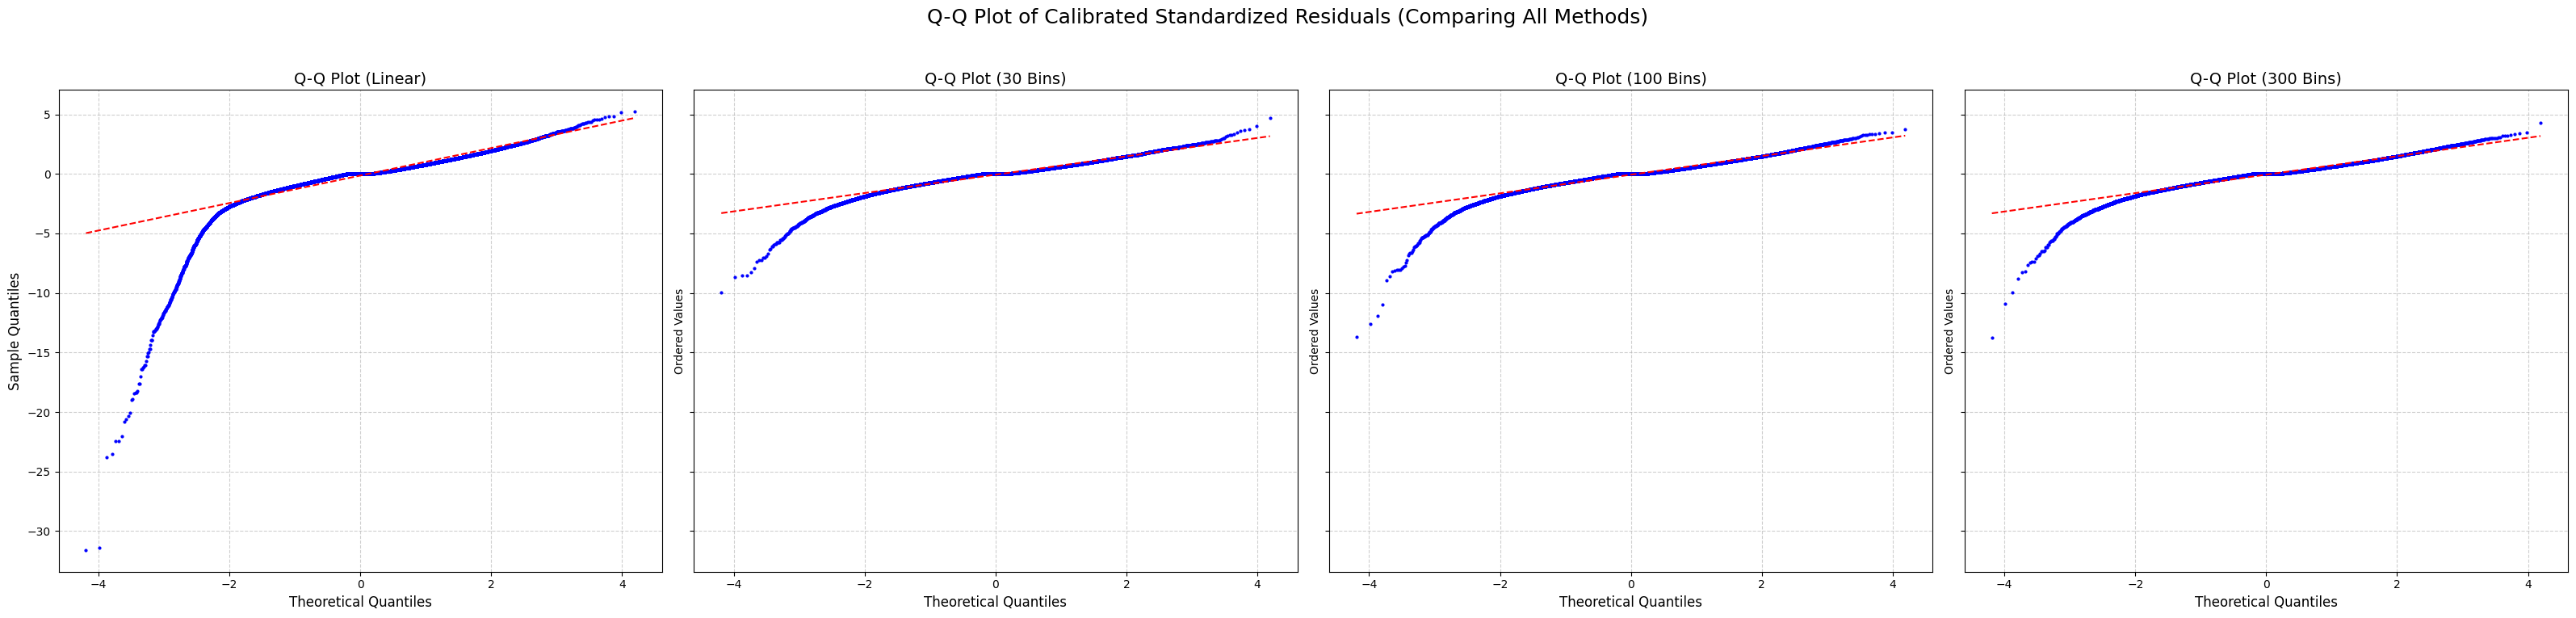


--- Results for Patient 16, Scan 02 (Evaluation Set) ---


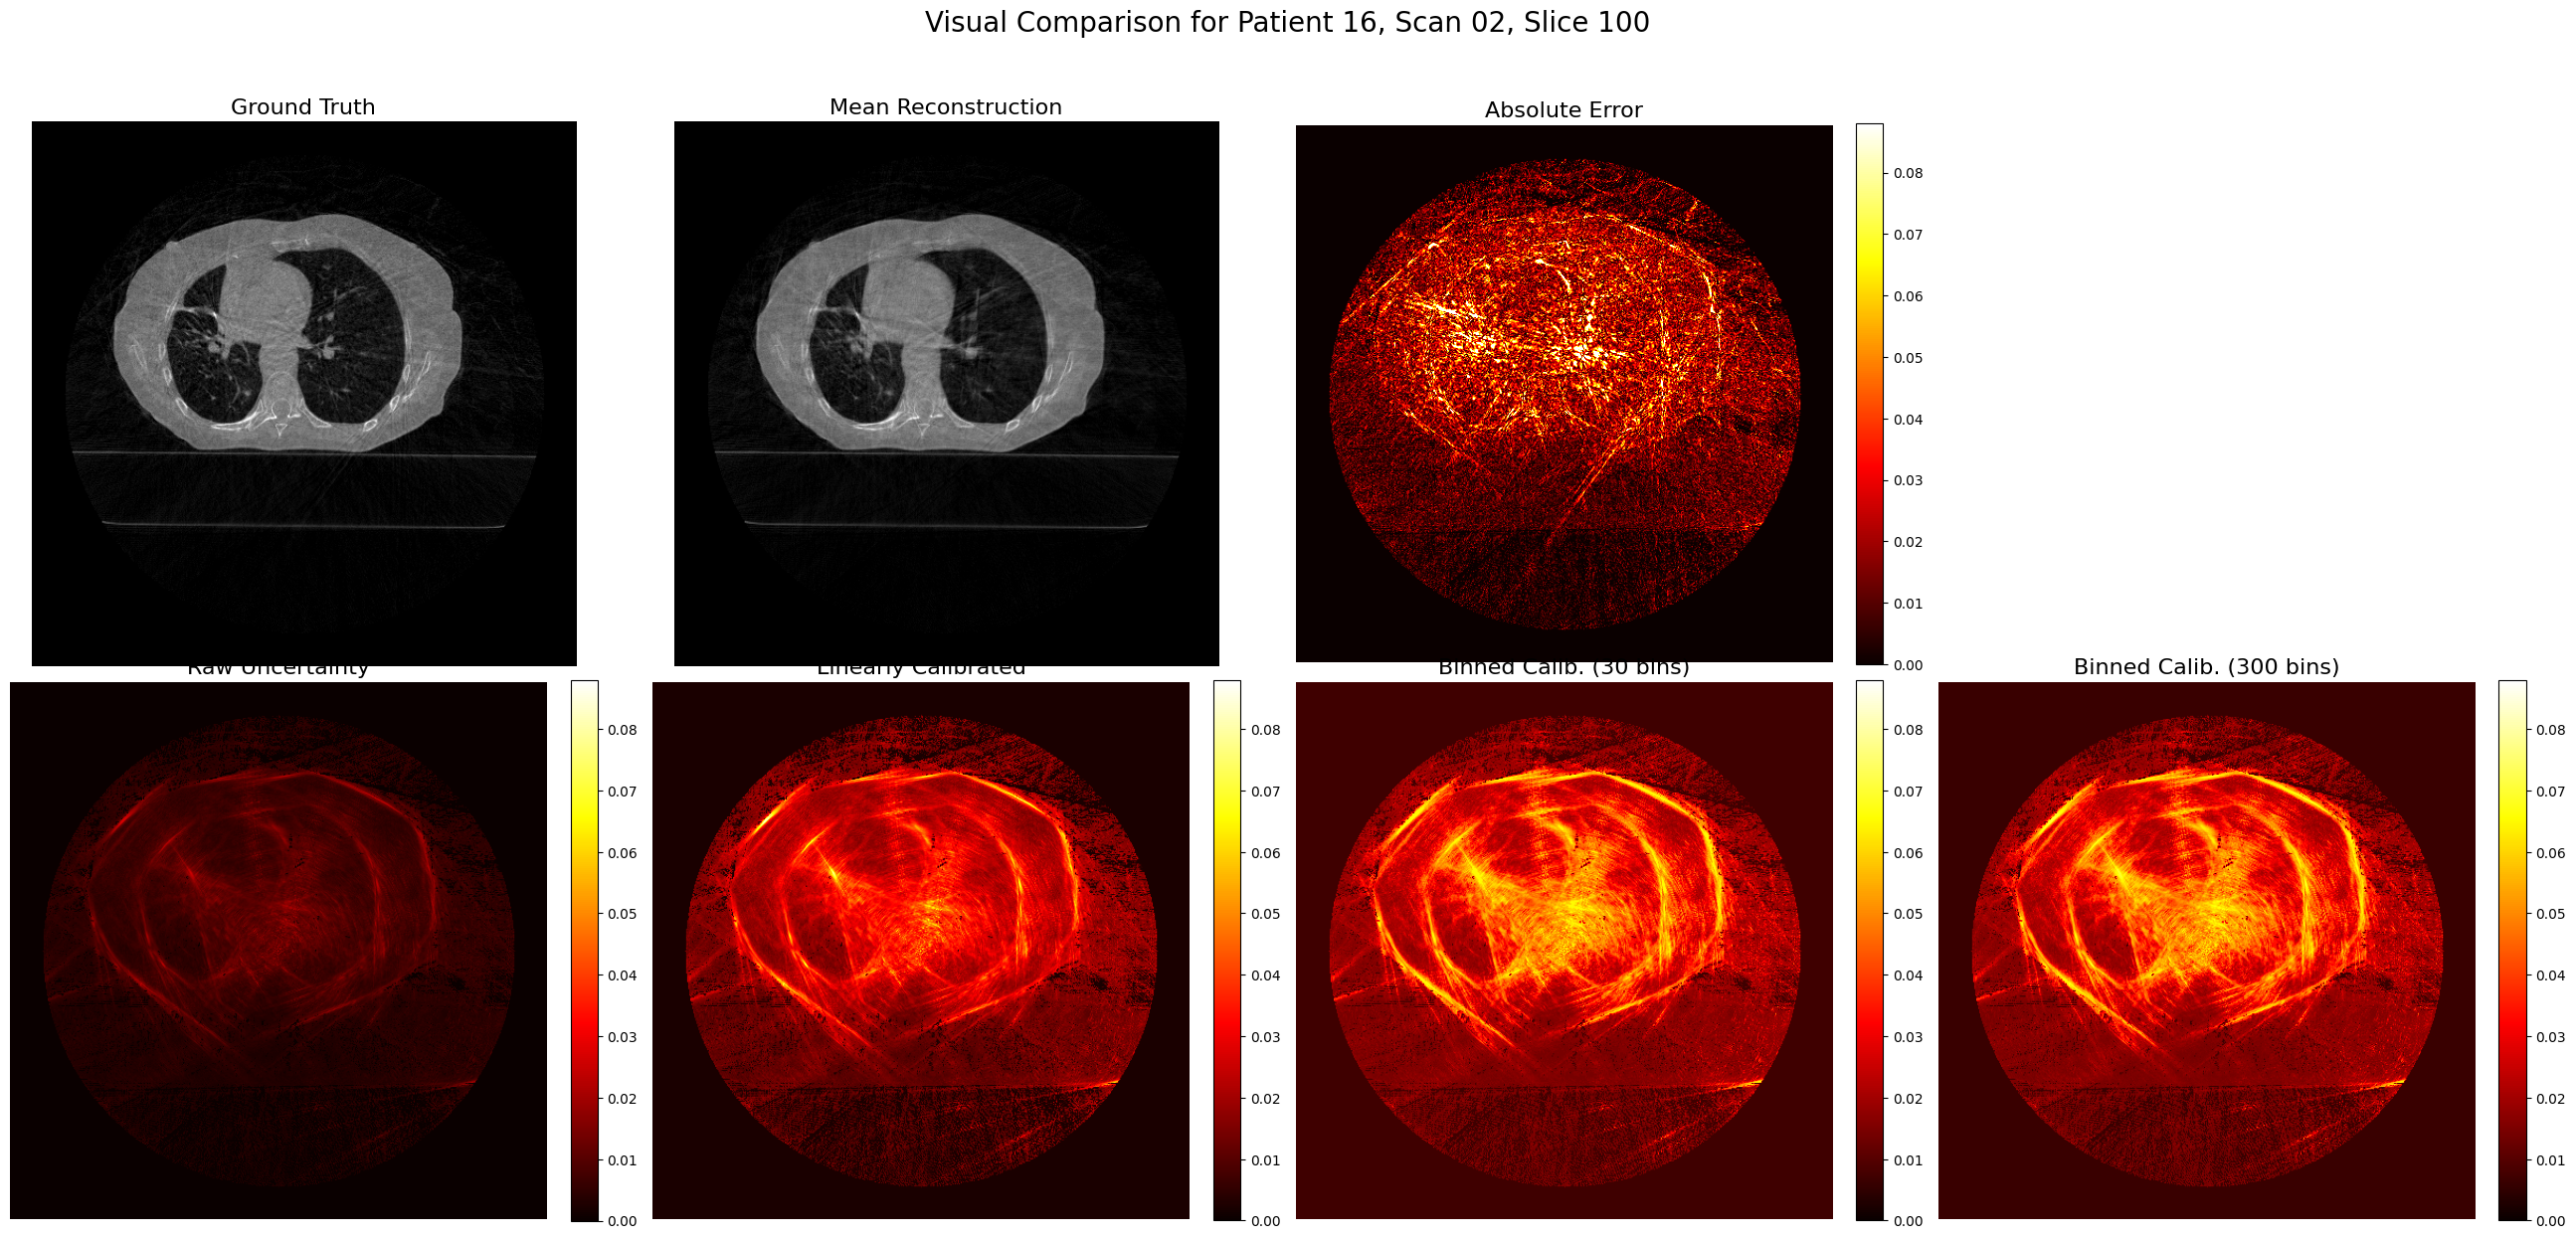

--- Final Quantitative Metrics for Patient 16, Scan 02 (Evaluation Set) ---

  Linear Calibration:
    Coverage (Ideal ~68%): 74.10%
    NLL (Lower is better): -3.4799

  Binned Calibration (30 bins):
    Coverage (Ideal ~68%): 83.82%
    NLL (Lower is better): -3.5253

  Binned Calibration (100 bins):
    Coverage (Ideal ~68%): 83.84%
    NLL (Lower is better): -3.5291

  Binned Calibration (300 bins):
    Coverage (Ideal ~68%): 83.86%
    NLL (Lower is better): -3.5324

--- Q-Q Plots for All Calibration Models ---


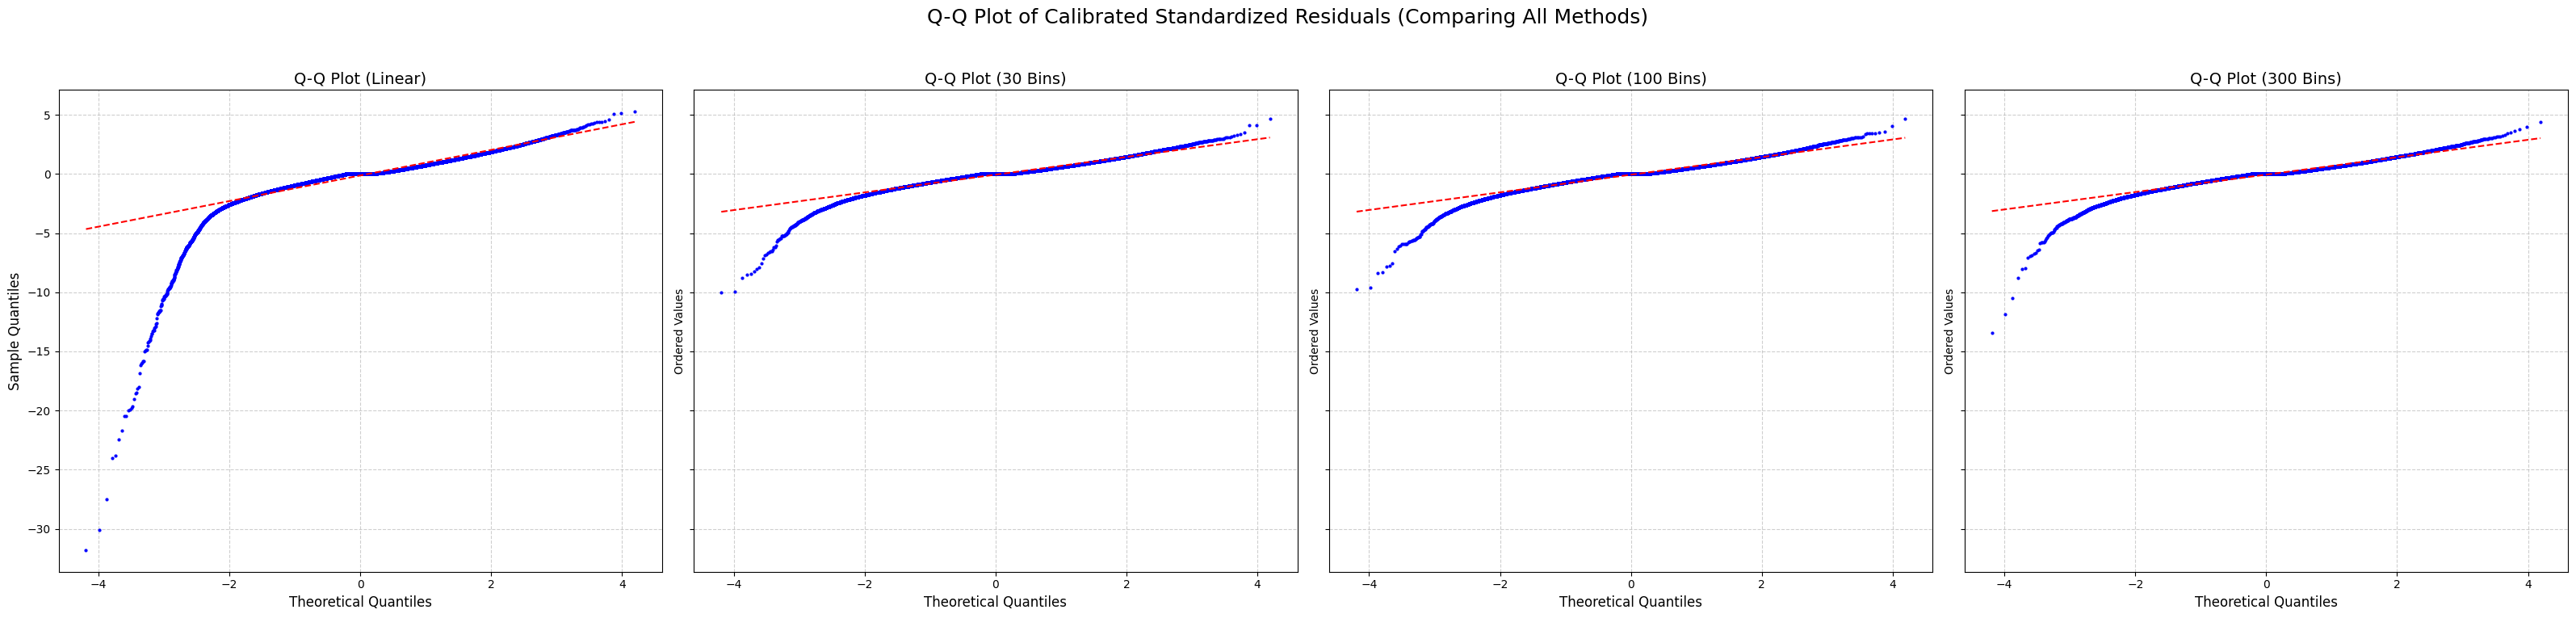

In [3]:
# 30 PCT